# QUBIC +

We try to construct another hypotetical instrument, QUBIC+ which is a combination of QUBIC and Simons obervatory experiments. 

The maps of S4 have these parameters :

$$\nu_i \hspace{1cm} \Delta \nu_i \hspace{1cm} \sigma_i$$

with $\nu$ is the frequency, $\Delta \nu$ is the bandwidth and $\sigma$ is the RMS of noise maps. The index $i$ is the sub-band of the observations. We consider now QUBIC+ with those parameters :

$$\nu_i \times n \hspace{1cm} \frac{\Delta \nu_i}{n} \hspace{1cm} \sigma_i \times \frac{\sqrt{n} \times (1 + \epsilon)}{f}$$

with $n$ the number of reconstruted sub-bands. $\epsilon$ is the relative optimality because of bolometric interferometry, $f$ is the fraction of CMB-S4 sensitivity and goes from $ \sqrt{n} \times (1 + \epsilon)$ to $1$.

In [8]:
import qubicplus
import CMBS4
import pysm3
import pysm3.units as u
from pysm3 import utils
import numpy as np
from qubic import camb_interface as qc
import healpy as hp
import matplotlib.pyplot as plt
import os
import random as rd
import string
import qubic
from importlib import reload
import pickle

plt.rc('figure',figsize=(16,4))
plt.rc('font',size=12)

center = qubic.equ2gal(0, -57)
# If there is not this command, the kernel shut down every time..
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

<Figure size 1152x288 with 0 Axes>

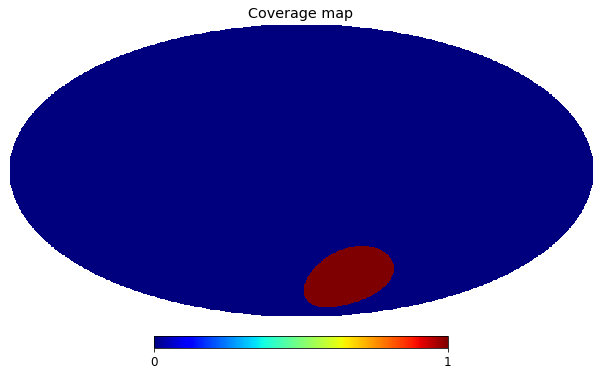

In [10]:
nside=256

def get_coverage(fsky, nside, center_radec=[0., -57.]):
    center = qubic.equ2gal(center_radec[0], center_radec[1])
    uvcenter = np.array(hp.ang2vec(center[0], center[1], lonlat=True))
    uvpix = np.array(hp.pix2vec(nside, np.arange(12*nside**2)))
    ang = np.arccos(np.dot(uvcenter, uvpix))
    indices = np.argsort(ang)
    okpix = ang < -1
    okpix[indices[0:int(fsky * 12*nside**2)]] = True
    mask = np.zeros(12*nside**2)
    mask[okpix] = 1
    return mask

covmap = get_coverage(0.03, nside)
skyconfig = {'cmb':42, 'dust':'d0'}

thr = 0.1
mymask = (covmap > (np.max(covmap)*thr)).astype(int)
pixok = mymask > 0

plt.figure()
hp.mollview(covmap, title = 'Coverage map', cmap='jet')
plt.show()

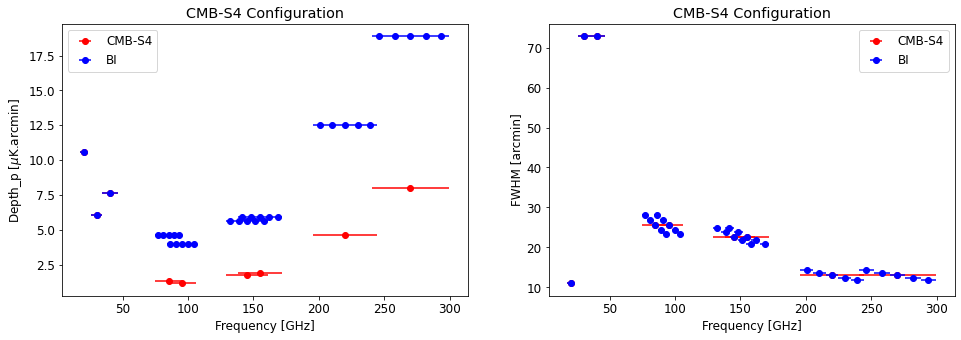

In [11]:
# Loading of dictionary from BI-CMBS4.ipynb 

### CMB-S4 config

freqs = np.array([20., 30., 40., 85., 95., 145., 155., 220., 270.])
bandwidth = np.array([5., 9., 12., 20.4, 22.8, 31.9, 34.1, 48.4, 59.4])
dnu_nu = bandwidth/freqs
beam_fwhm = np.array([11., 72.8, 72.8, 25.5, 25.5, 22.7, 22.7, 13., 13.])
mukarcmin_TT = np.array([16.5, 9.36, 11.85, 2.02, 1.78, 3.89, 4.16, 10.15, 17.4])
mukarcmin_EE = np.array([10.87, 6.2, 7.85, 1.34, 1.18, 1.8, 1.93, 4.71, 8.08])
mukarcmin_BB = np.array([10.23, 5.85, 7.4, 1.27, 1.12, 1.76, 1.89, 4.6, 7.89])
ell_min = np.array([30, 30, 30, 30, 30, 30, 30, 30, 30])
nside = np.array([512, 512, 512, 512, 512, 512, 512, 512, 512])
edges_min = freqs * (1. - dnu_nu/2)
edges_max = freqs * (1. + dnu_nu/2)
edges = [[edges_min[i], edges_max[i]] for i in range(len(freqs))]
s4_config = {
    'nbands': len(freqs),
    'frequency': freqs,
    'depth_p': 0.5*(mukarcmin_EE + mukarcmin_BB),
    'depth_i': mukarcmin_TT,
    'depth_e': mukarcmin_EE,
    'depth_b': mukarcmin_BB,
    'fwhm': beam_fwhm,
    'bandwidth': bandwidth,
    'dnu_nu': dnu_nu,
    'ell_min': ell_min,
    'nside': nside,
    'fsky': 0.03,
    'ntubes': 12,
    'nyears': 7.,
    'edges': edges,
    'effective_fraction': np.zeros(len(freqs))+1.
            }

def fct_subopt(nus):
    subnus = [150., 220]
    subval = [1.4, 1.2]
    fct_subopt = np.poly1d(np.polyfit(subnus, subval, 1))
    return fct_subopt(nus)

subnus = [150., 220]
subval = [1.4, 1.2]

def get_coverage(fsky, nside, center_radec=[0., -57.]):
    center = qubic.equ2gal(center_radec[0], center_radec[1])
    uvcenter = np.array(hp.ang2vec(center[0], center[1], lonlat=True))
    uvpix = np.array(hp.pix2vec(nside, np.arange(12*nside**2)))
    ang = np.arccos(np.dot(uvcenter, uvpix))
    indices = np.argsort(ang)
    okpix = ang < -1
    okpix[indices[0:int(fsky * 12*nside**2)]] = True
    mask = np.zeros(12*nside**2)
    mask[okpix] = 1
    return mask

def qubicify(config, qp_nsub, qp_effective_fraction):
    nbands = np.sum(qp_nsubs)
    qp_config = config.copy()
    for k in qp_config.keys():
        qp_config[k]=[]
    qp_config['nbands'] = nbands
    qp_config['fsky'] = config['fsky']
    qp_config['ntubes'] = config['ntubes']
    qp_config['nyears'] = config['nyears']
    qp_config['initial_band'] = []

    for i in range(len(config['frequency'])):
        #print(config['edges'][i][0], config['edges'][i][-1])
        newedges = np.linspace(config['edges'][i][0], config['edges'][i][-1], qp_nsubs[i]+1)
        #print(newedges)
        newfreqs = (newedges[0:-1]+newedges[1:])/2
        newbandwidth = newedges[1:] - newedges[0:-1]
        newdnu_nu = newbandwidth / newfreqs
        newfwhm = config['fwhm'][i] * config['frequency'][i]/newfreqs
        scalefactor_noise = np.sqrt(qp_nsubs[i]) * fct_subopt(config['frequency'][i]) / qp_effective_fraction[i]
        newdepth_p = config['depth_p'][i] * np.ones(qp_nsub[i]) * scalefactor_noise
        newdepth_i = config['depth_i'][i] * np.ones(qp_nsub[i]) * scalefactor_noise
        newdepth_e = config['depth_e'][i] * np.ones(qp_nsub[i]) * scalefactor_noise
        newdepth_b = config['depth_b'][i] * np.ones(qp_nsub[i]) * scalefactor_noise
        newell_min = np.ones(qp_nsub[i]) * config['ell_min'][i]
        newnside = np.ones(qp_nsub[i]) * config['nside'][i]
        neweffective_fraction = np.ones(qp_nsub[i]) * qp_effective_fraction[i]
        initial_band = np.ones(qp_nsub[i]) * config['frequency'][i]

        for k in range(qp_nsubs[i]):
            if qp_effective_fraction[i] != 0:
                qp_config['frequency'].append(newfreqs[k])
                if i >= 3:
                    qp_config['depth_p'].append(newdepth_p[k])
                    qp_config['depth_i'].append(newdepth_i[k])
                    qp_config['depth_e'].append(newdepth_e[k])
                    qp_config['depth_b'].append(newdepth_b[k])
                else:
                    qp_config['depth_p'].append(s4_config['depth_p'][i])
                    qp_config['depth_i'].append(s4_config['depth_i'][i])
                    qp_config['depth_e'].append(s4_config['depth_e'][i])
                    qp_config['depth_b'].append(s4_config['depth_b'][i])
                qp_config['fwhm'].append(newfwhm[k])
                qp_config['bandwidth'].append(newbandwidth[k])
                qp_config['dnu_nu'].append(newdnu_nu[k])
                qp_config['ell_min'].append(newell_min[k])
                qp_config['nside'].append(newnside[k])

                qp_config['effective_fraction'].append(neweffective_fraction[k])
                qp_config['initial_band'].append(initial_band[k])
        for k in range(qp_nsubs[i]+1):
            if qp_effective_fraction[i] != 0:
                qp_config['edges'].append(newedges[k])

        #qp_config['depth_p'][:3] = s4_config['depth_p'][:3]
        #qp_config['depth_i'][:3] = s4_config['depth_i'][:3]

    fields = ['frequency', 'depth_p', 'depth_i', 'depth_e', 'depth_b', 'fwhm', 'bandwidth',
              'dnu_nu', 'ell_min', 'nside', 'edges', 'effective_fraction', 'initial_band']
    for j in range(len(fields)):
        qp_config[fields[j]] = np.array(qp_config[fields[j]])

    return qp_config


covmap = get_coverage(0.03, nside=256)
thr = 0.1
mymask = (covmap > (np.max(covmap)*thr)).astype(int)
pixok = mymask > 0


qp_nsubs = np.array([1, 1, 1, 5, 5, 5, 5, 5, 5])
qp_effective_fraction = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1])
qp_config=qubicify(s4_config, qp_nsubs, qp_effective_fraction)


plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plt.errorbar(s4_config['frequency'], s4_config['depth_p'], xerr=s4_config['bandwidth']/2, fmt='ro', label='CMB-S4')
plt.errorbar(qp_config['frequency'], qp_config['depth_p'], xerr=qp_config['bandwidth']/2, fmt='bo', label='BI')
plt.xlabel('Frequency [GHz]')
plt.ylabel(r'Depth_p [$\mu$K.arcmin]')
plt.title('CMB-S4 Configuration')
plt.legend()
plt.subplot(1,2,2)
plt.errorbar(s4_config['frequency'], s4_config['fwhm'], xerr=s4_config['bandwidth']/2, fmt='ro', label='CMB-S4')
plt.errorbar(qp_config['frequency'], qp_config['fwhm'], xerr=qp_config['bandwidth']/2, fmt='bo', label='BI')
plt.xlabel('Frequency [GHz]')
plt.ylabel('FWHM [arcmin]')
plt.title('CMB-S4 Configuration')
plt.legend()
plt.show()

In [7]:
reload(qubicplus)

qp=qubicplus.BImaps(skyconfig, s4_config)

mapS4_noisy, mapS4_noiseless, noiseS4 = qp.getskymaps(same_resol=0, 
                                                      iib=False, 
                                                      verbose=True, 
                                                      coverage=covmap, 
                                                      noise=True, 
                                                      signoise=1.)

NameError: name 'qubicplus' is not defined

In [13]:
reload(qubicplus)

qp=qubicplus.BImaps(skyconfig, s4_config)

mapS4_noisy_conv, mapS4_noiseless_conv, noiseS4_conv = qp.getskymaps(same_resol=0.5, 
                                                      iib=False, 
                                                      verbose=True, 
                                                      coverage=covmap, 
                                                      noise=True, 
                                                      signoise=1.)

    FWHM : [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5] deg 
    nus : [ 20.  30.  40.  85.  95. 145. 155. 220. 270.] GHz 
    Bandwidth : [ 5.   9.  12.  20.4 22.8 31.9 34.1 48.4 59.4] GHz


Model : d0 -> Spectral index beta is constant on the sky (set to 1.54)
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg


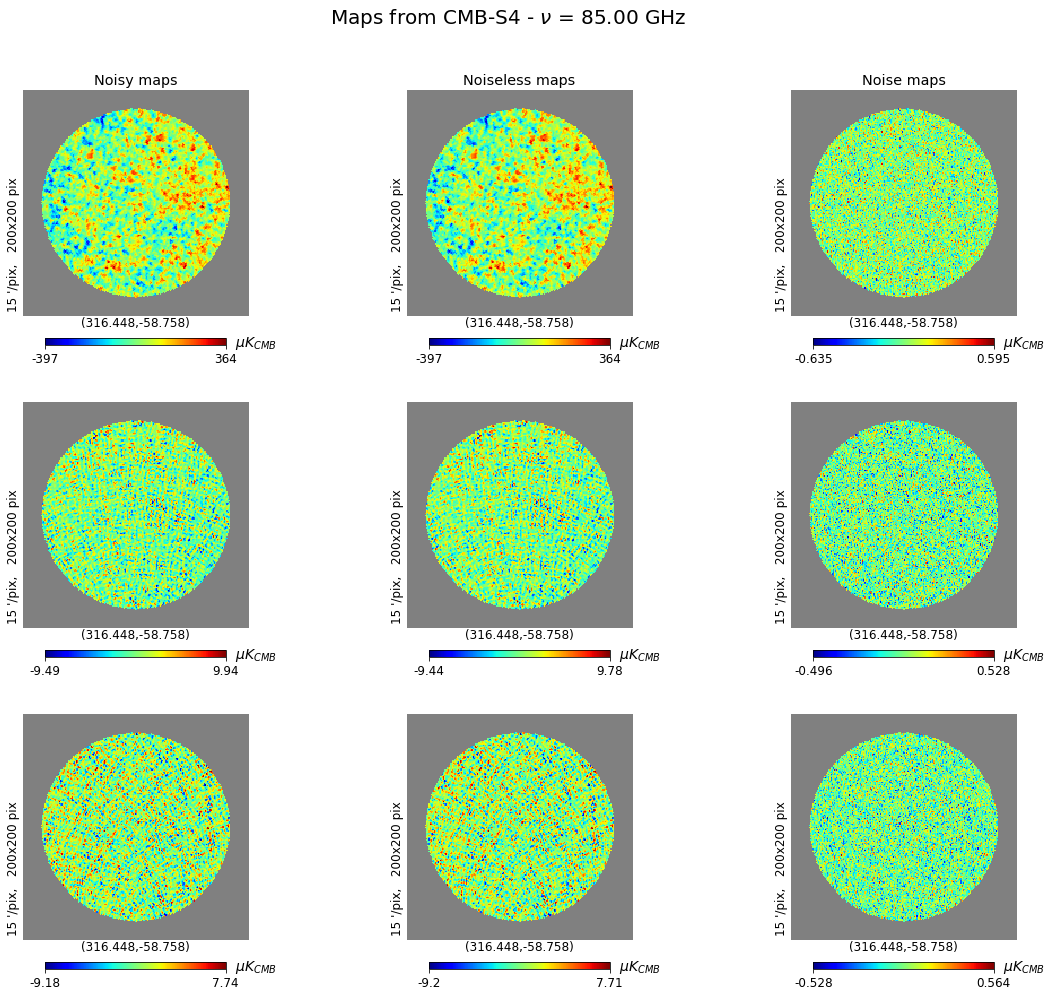

In [14]:
f=3

plt.figure(figsize=(16, 13))
hp.gnomview(mapS4_noisy[f, 0], rot=center, reso=15, cmap='jet', sub=(3, 3, 1), title='Noisy maps', 
            unit=r'$\mu K_{CMB}$')
hp.gnomview(mapS4_noiseless[f, 0], rot=center, reso=15, cmap='jet', sub=(3, 3, 2), title='Noiseless maps', 
            unit=r'$\mu K_{CMB}$')
hp.gnomview(noiseS4[f, 0], rot=center, reso=15, cmap='jet', sub=(3, 3, 3), title='Noise maps', 
            unit=r'$\mu K_{CMB}$')

hp.gnomview(mapS4_noisy[f, 1], rot=center, reso=15, cmap='jet', sub=(3, 3, 4), title='', 
            unit=r'$\mu K_{CMB}$')
hp.gnomview(mapS4_noiseless[f, 1], rot=center, reso=15, cmap='jet', sub=(3, 3, 5), title='', 
            unit=r'$\mu K_{CMB}$')
hp.gnomview(noiseS4[f, 1], rot=center, reso=15, cmap='jet', sub=(3, 3, 6), title='', 
            unit=r'$\mu K_{CMB}$')

hp.gnomview(mapS4_noisy[f, 2], rot=center, reso=15, cmap='jet', sub=(3, 3, 7), title='', 
            unit=r'$\mu K_{CMB}$')
hp.gnomview(mapS4_noiseless[f, 2], rot=center, reso=15, cmap='jet', sub=(3, 3, 8), title='', 
            unit=r'$\mu K_{CMB}$')
hp.gnomview(noiseS4[f, 2], rot=center, reso=15, cmap='jet', sub=(3, 3, 9), title='', 
            unit=r'$\mu K_{CMB}$')

plt.suptitle(r'Maps from CMB-S4 - $\nu$ = {:.2f} GHz'.format(s4_config['frequency'][f]), fontsize=20, y=1.05)
plt.show()

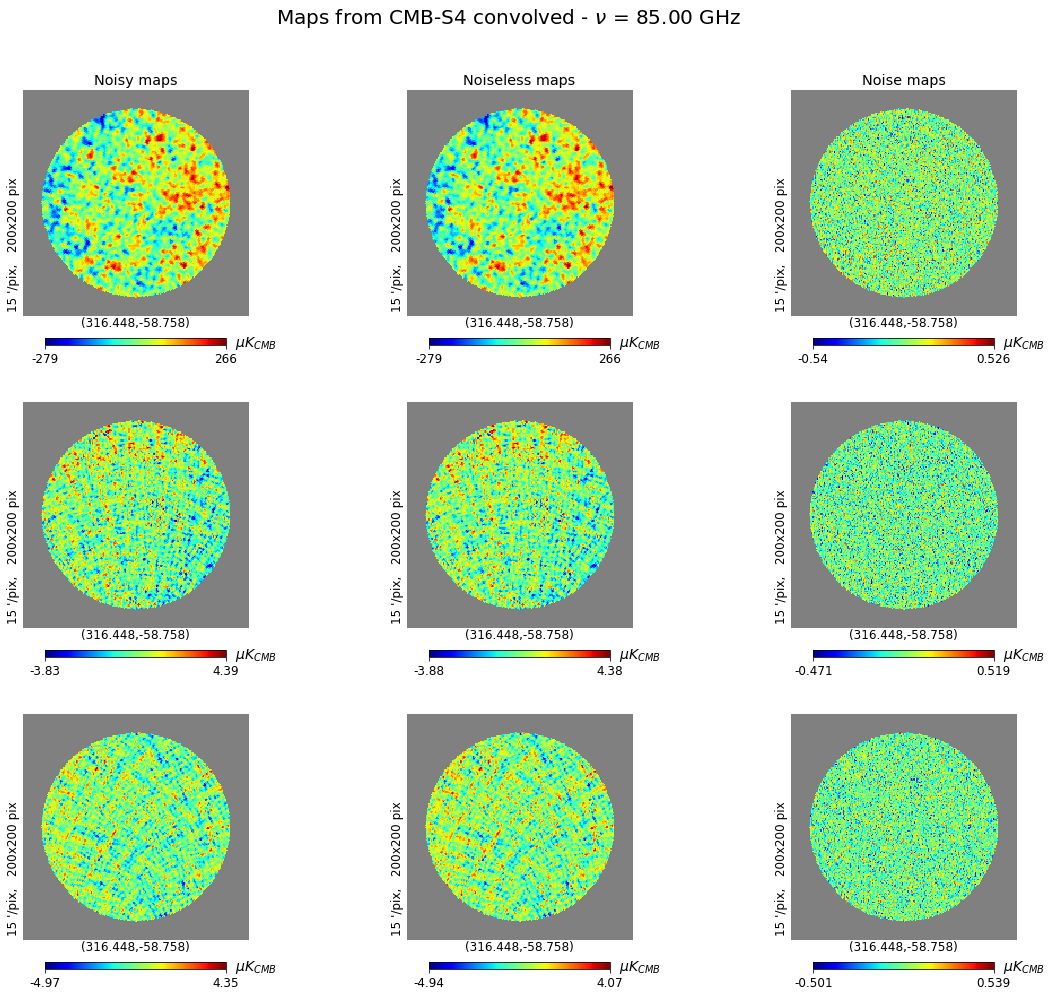

In [15]:
f=3

plt.figure(figsize=(16, 13))
hp.gnomview(mapS4_noisy_conv[f, 0], rot=center, reso=15, cmap='jet', sub=(3, 3, 1), title='Noisy maps', 
            unit=r'$\mu K_{CMB}$')
hp.gnomview(mapS4_noiseless_conv[f, 0], rot=center, reso=15, cmap='jet', sub=(3, 3, 2), title='Noiseless maps', 
            unit=r'$\mu K_{CMB}$')
hp.gnomview(noiseS4_conv[f, 0], rot=center, reso=15, cmap='jet', sub=(3, 3, 3), title='Noise maps', 
            unit=r'$\mu K_{CMB}$')

hp.gnomview(mapS4_noisy_conv[f, 1], rot=center, reso=15, cmap='jet', sub=(3, 3, 4), title='', 
            unit=r'$\mu K_{CMB}$')
hp.gnomview(mapS4_noiseless_conv[f, 1], rot=center, reso=15, cmap='jet', sub=(3, 3, 5), title='', 
            unit=r'$\mu K_{CMB}$')
hp.gnomview(noiseS4_conv[f, 1], rot=center, reso=15, cmap='jet', sub=(3, 3, 6), title='', 
            unit=r'$\mu K_{CMB}$')

hp.gnomview(mapS4_noisy_conv[f, 2], rot=center, reso=15, cmap='jet', sub=(3, 3, 7), title='', 
            unit=r'$\mu K_{CMB}$')
hp.gnomview(mapS4_noiseless_conv[f, 2], rot=center, reso=15, cmap='jet', sub=(3, 3, 8), title='', 
            unit=r'$\mu K_{CMB}$')
hp.gnomview(noiseS4_conv[f, 2], rot=center, reso=15, cmap='jet', sub=(3, 3, 9), title='', 
            unit=r'$\mu K_{CMB}$')

plt.suptitle(r'Maps from CMB-S4 convolved - $\nu$ = {:.2f} GHz'.format(s4_config['frequency'][f]), fontsize=20, y=1.05)
plt.show()

In [12]:
from importlib import reload

reload(qubicplus)

mapqp_noisy, mapqp_noiseless, noiseqp = qubicplus.BImaps(skyconfig, qp_config).getskymaps(same_resol=0, 
                                                      iib=False, 
                                                      verbose=True, 
                                                      coverage=covmap, 
                                                      noise=True, 
                                                      signoise=1.)

    FWHM : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.] deg 
    nus : [ 20.    30.    40.    76.84  80.92  85.    89.08  93.16  85.88  90.44
  95.    99.56 104.12 132.24 138.62 145.   151.38 157.76 141.36 148.18
 155.   161.82 168.64 200.64 210.32 220.   229.68 239.36 246.24 258.12
 270.   281.88 293.76] GHz 
    Bandwidth : [ 5.    9.   12.    4.08  4.08  4.08  4.08  4.08  4.56  4.56  4.56  4.56
  4.56  6.38  6.38  6.38  6.38  6.38  6.82  6.82  6.82  6.82  6.82  9.68
  9.68  9.68  9.68  9.68 11.88 11.88 11.88 11.88 11.88] GHz


Model : d0


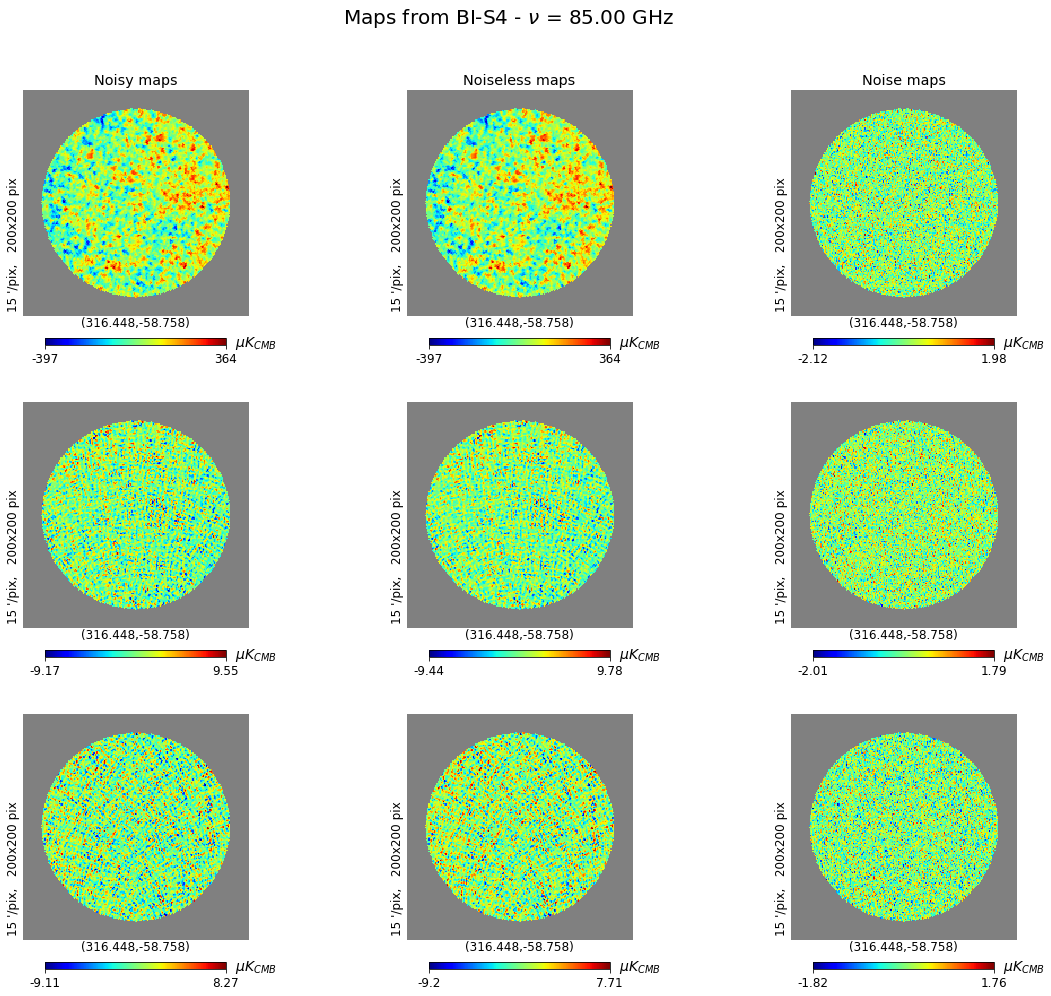

In [17]:
f=5

plt.figure(figsize=(16, 13))
hp.gnomview(mapqp_noisy[f, 0], rot=center, reso=15, cmap='jet', sub=(3, 3, 1), title='Noisy maps', 
            unit=r'$\mu K_{CMB}$')
hp.gnomview(mapqp_noiseless[f, 0], rot=center, reso=15, cmap='jet', sub=(3, 3, 2), title='Noiseless maps', 
            unit=r'$\mu K_{CMB}$')
hp.gnomview(noiseqp[f, 0], rot=center, reso=15, cmap='jet', sub=(3, 3, 3), title='Noise maps', 
            unit=r'$\mu K_{CMB}$')

hp.gnomview(mapqp_noisy[f, 1], rot=center, reso=15, cmap='jet', sub=(3, 3, 4), title='', 
            unit=r'$\mu K_{CMB}$')
hp.gnomview(mapqp_noiseless[f, 1], rot=center, reso=15, cmap='jet', sub=(3, 3, 5), title='', 
            unit=r'$\mu K_{CMB}$')
hp.gnomview(noiseqp[f, 1], rot=center, reso=15, cmap='jet', sub=(3, 3, 6), title='', 
            unit=r'$\mu K_{CMB}$')

hp.gnomview(mapqp_noisy[f, 2], rot=center, reso=15, cmap='jet', sub=(3, 3, 7), title='', 
            unit=r'$\mu K_{CMB}$')
hp.gnomview(mapqp_noiseless[f, 2], rot=center, reso=15, cmap='jet', sub=(3, 3, 8), title='', 
            unit=r'$\mu K_{CMB}$')
hp.gnomview(noiseqp[f, 2], rot=center, reso=15, cmap='jet', sub=(3, 3, 9), title='', 
            unit=r'$\mu K_{CMB}$')

plt.suptitle(r'Maps from BI-S4 - $\nu$ = {:.2f} GHz'.format(qp_config['frequency'][f]), fontsize=20, y=1.05)
plt.show()